## Recommendations

1. Please consider avoiding the for-loop when possible. The following is the reference code for using built-in function:

`new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation`

2. It might be helpful to have the null hypothesis written only in equality form: [here](https://stats.stackexchange.com/questions/243212/why-does-the-null-hypothesis-have-to-be-equals-to-and-not-greater-than-or-equ)

3. Introduction to Hypothesis Testing: [here](https://onlinecourses.science.psu.edu/stat500/node/39/)

## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

### Should we implement the new web page?

1. Understand the results of an A/B test run by an e-commerce website.
2. A new web page in order to try and increase the number of users who “convert”:
    - Meaning the number of users who decide to pay for the company's product;
    - Total number of unique users who bought the product/Total number of unique users;
3. Dataset: `ab_data.csv`
4. Goal:
    - Implement this new page.
    - Keep the old page.
    - Run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [64]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### #1. Assess Data (Understanding the Dataset)

1. The number of rows in the dataset:
    - 294478
2. The number of unique users in the dataset: 
    - 290584
3. The proportion of users converted: 
    - 12%
4. The number of times the `new_page` and `treatment` don't line up:
    - 3893
5. Do any of the rows have missing values? 
    - No

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [6]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [7]:
# number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [8]:
# number of unique users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [9]:
df.query('converted == 1').user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [11]:
df.groupby(['landing_page', 'group'], as_index=False).count()

,landing_page,group,user_id,timestamp,converted
0,new_page,control,1928,1928,1928
1,new_page,treatment,145311,145311,145311
2,old_page,control,145274,145274,145274
3,old_page,treatment,1965,1965,1965


In [12]:
df.query("group == 'treatment' and landing_page != 'new_page' or group != 'treatment' and landing_page == 'new_page'").shape[0]

3893

f. Do any of the rows have missing values?

In [13]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### #2. Clean Messy Data

1. Remove rows for the number of times the `new_page` and `treatment` don't line up
    - 3893 rows
2. Check if there are duplicates in the dataset by `user_id`
    - There are two duplicates
    - Remove one of the rows with an id of `773192`

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [14]:
df2  = df.drop(df.query("group == 'treatment' and landing_page != 'new_page' or group != 'treatment' and landing_page == 'new_page'").index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
df2.groupby(['landing_page', 'group'], as_index=False).count()

,landing_page,group,user_id,timestamp,converted
0,new_page,treatment,145311,145311,145311
1,old_page,control,145274,145274,145274


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [17]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [18]:
df2.groupby('user_id', as_index=False).timestamp.count().sort_values(by='timestamp', ascending=False).iloc[0,:]

user_id      773192
timestamp         2
Name: 131712, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [19]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### #3. Updated DataFrame: df2

1. The number of unique ids in df2:
    - 290584
2. Probability of converting regardless of page:
    - 0.1196
3. Given an individual received the control page, the probability of converting:
    - 0.1204
4. The probability of receiving the new page, old pags.
    - 0.5001, 0.4999
5. Difference in observed proportions:
    - -0.0016
6. How long was the experiment run for?
    - 22 days

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [20]:
df2.drop(df2.loc[[1899],:].index, inplace=True)
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [21]:
df['converted'].mean()

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [22]:
df2.query('group == "control" and converted == 1').shape[0]/df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [23]:
df2.query('group == "treatment" and converted == 1').shape[0]/df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [24]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

In [25]:
# What is the probability that an individual received the old page?
df2.query('landing_page == "old_page"').shape[0]/df2.shape[0]

0.4999380557773312

#### Observed Difference in Proportions

In [26]:
obs_diff = df2.query('group == "treatment" and converted == 1').shape[0]/df2.query('group == "treatment"').shape[0] - df2.query('group == "control" and converted == 1').shape[0]/df2.query('group == "control"').shape[0]
obs_diff

-0.0015782389853555567

#### How long was the experiment run for? 

In [29]:
# take a look at the timestamp data
df2.timestamp.head(1)

0    2017-01-21 22:11:48.556739
Name: timestamp, dtype: object

In [28]:
# check datatypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [30]:
# transform timestamp to datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'] )
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null datetime64[ns]
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.3+ MB


In [31]:
# how long was this experiment run for?
max(df2.timestamp) - min(df2.timestamp)

Timedelta('21 days 23:59:49.081927')

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

###  Is there sufficient evidence to say that the new treatment page leads to more conversions?

The probability that an individual received the new page is 50.01% and the probability that an individual received the old page is almost the same, 49,99%. Therefore, there is an almost equal chance for an individual receiving either of the two available versions of the web page. There is almost no difference in the number of users in the control and experimental group.

From the total of 290,584 distinct users:
- half are in the treatment or experimental group, receiving the new page; 
- half are in the control group, receiving the old page;
- with a difference in proportions of buying the product of -0.0016.

Furthermore, the probability of an individual buying the product regardless of the page they receive is around the same as the probability of an individual buying the product if they are in the control or experimental group, at around 12%.

The observed difference in probabilities between groups is around 0 (-0.0016). Based on the difference in probabilities it appears that the new landing page doesn’t make users buy the product more than the old version of the website. In order to fully understand if the new page does lead to better conversion rate we also need to know if the experiment was run long enough to provide significant results. 

We have to keep in mind for:
- Change Aversion: Existing users may give an unfair advantage to the old version, simply because they are unhappy with change, even if it’s ultimately for the better.
- Novelty Effect: Existing users may give an unfair advantage to the new version, because they’re excited or drawn to the change, even if it isn’t any better in the long run.

Therefore, the test needs to be implemented long enough to minimize change aversion and novelty effect.

We can see above that the experiment was run for around 22 days. Hence, there is not sufficient evidence to say that the new treatment does not lead to more conversions. We should repeat the experiment to see if it leads to more conversions or not.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

### #4. Hypothesis Testing:

1. The old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? 
$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$
2. Assume $H_0$ is true:
    - $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted
    - $p_{new}$ = $p_{old}$= $p_{converted}$= 0.1196
    - $n_{new}$ = 145310
    - $n_{old}$ = 145274
    - Observed difference under null = $p_{new}$ - $p_{old}$ = 0
3. Simulate under the null:
    - Simulate $n_{new}$ transactions with a convert rate of p_{new}  in new_page_converted
    - Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ in old_page_converted
    - Find $p_{new}$ - $p_{old}$ for the simulated values
    - $p_{new}$ - $p_{old}$ = -0.0017
4. Simulate $p_{new}$ - $p_{old}$ for 10,000 times:
    - store in p_diffs
5. Plot a histogram of p_diffs:
    - Normal histogram
5. What proportion of the p_diffs are greater than the actual difference observed in our original DataFrame?
    - 0.90

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [32]:
# observed difference
obs_diff

-0.0015782389853555567

a. What is the **convert rate** for $p_{new}$ under the null? 

In [33]:
p_new = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [34]:
p_old = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [35]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [36]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

In [37]:
# obs difference under null, no difference between convertions
obs_dif_null = p_new - p_old
obs_dif_null

0.0

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

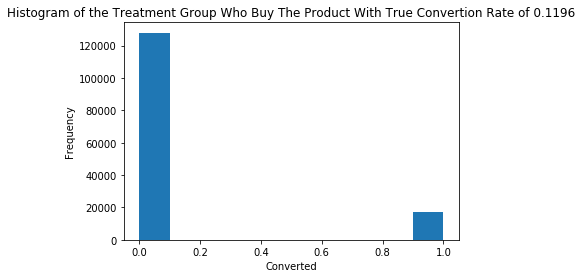

In [41]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
plt.hist(new_page_converted)
plt.title('Histogram of the Treatment Group Who Buy The Product With True Convertion Rate of 0.1196')
plt.ylabel('Frequency')
plt.xlabel('Converted')
plt.show();

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

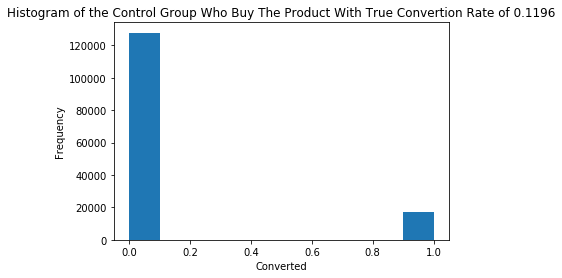

In [42]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
plt.hist(old_page_converted)
plt.title('Histogram of the Control Group Who Buy The Product With True Convertion Rate of 0.1196')
plt.ylabel('Frequency')
plt.xlabel('Converted')
plt.show();

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [91]:
new_page_converted.mean() - old_page_converted.mean()

-0.00049067993080173511

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [49]:
# difference in probabilities array
p_diffs = []
p_new_page = []
p_old_page = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
    p_new_page.append(new_page_converted.mean())
    p_old_page.append(old_page_converted.mean())
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

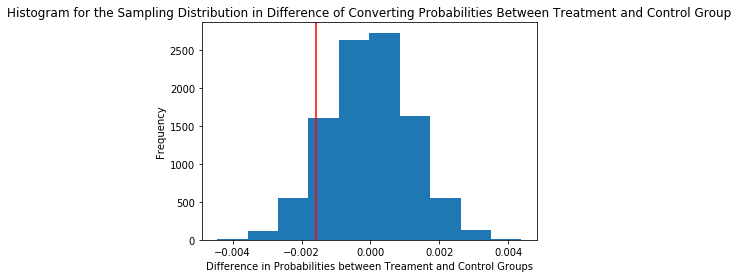

In [92]:
# transform array into numpy array
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

# where our observed statistic falls in the sampling distribution
plt.axvline(x=obs_diff, color='red')

plt.title('Histogram for the Sampling Distribution in Difference of Converting Probabilities Between Treatment and Control Group')
plt.ylabel('Frequency')
plt.xlabel('Difference in Probabilities between Treament and Control Groups')
plt.show();

The histogram looks normally distributed, as expected from the Central Limit Theorem.

In [93]:
# transform array into numpy array
p_diffs = np.array(p_diffs)

# build a 95% confidence interval
low, upper = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)
low, upper

(-0.0023626158529835347, 0.0023109076102294152)

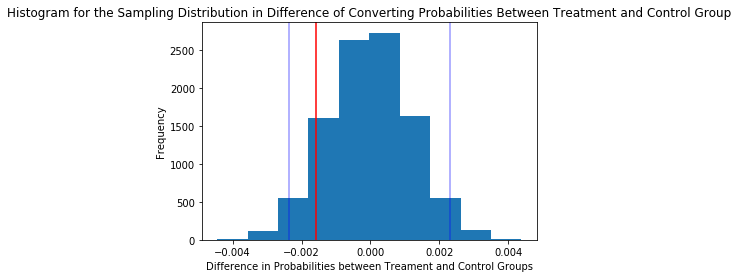

In [94]:
plt.hist(p_diffs);

# where our observed statistic falls in the sampling distribution
plt.axvline(x=obs_diff, color='red')
plt.axvline(x=low, color='blue', alpha=0.3, linewidth=2);
plt.axvline(x=upper, color='blue', alpha=0.3, linewidth=2);

plt.title('Histogram for the Sampling Distribution in Difference of Converting Probabilities Between Treatment and Control Group')
plt.ylabel('Frequency')
plt.xlabel('Difference in Probabilities between Treament and Control Groups')
plt.show();

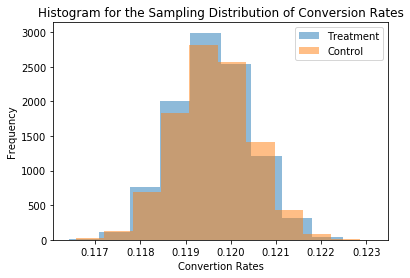

In [95]:
plt.hist(p_new_page, alpha = 0.5, label='Treatment');
plt.hist(p_old_page, alpha = 0.5, label='Control'); 
plt.title('Histogram for the Sampling Distribution of Conversion Rates')
plt.ylabel('Frequency')
plt.xlabel('Convertion Rates')
plt.legend()
plt.show();

- We can see that our observed difference falls inside our 95% Confidence Interval where our true difference would be which suggets the null is actually true.
- Also, by looking at the Histogram of Sampling Distributions we can see that there isn't much difference between them. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [96]:
(p_diffs > obs_diff).mean()

0.90100000000000002

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

### P-Value Conclusions:

1. I computed the P-value which is the probability of observing our statistic if the null hypothesis is true. In other words, I computed the probability of getting a difference in means of users who buy the product from the new page and the old page to be around -0.0016 assuming the probability of users who buy the product from the new page and the old page is equal to 0.1196.
2. The probability of observing the difference in probabilities is large. At around 90%, the difference in probabilities for the control group and the experiment does not appear to be significant.
3. At a p-value of around 0.90, we fail to reject the Null.
4. Therefore, there is evidence in favor of the null hypothesis, not implementing the new web page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [55]:
convert_old = df2.query('group == "control" and converted == 1').shape[0]/df2.query('group == "control"').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]/df2.query('group == "treatment"').shape[0]
 
convert_old, convert_new, n_old, n_new 

(0.1203863045004612, 0.11880806551510564, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.


The Hypothesis

- The null hypothesis is that there is no difference between the two proportions.
- The alternative is that there is a statistical difference between the two proportions.

In [56]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
z_score, p_value

(-0.0032875796753531767, 0.99737689565979126)

In [57]:
norm.cdf(z_score), norm.ppf(1-(0.05/2))
# 0.49868844782989563 # Tells us how significant our z-score is
# 1.959963984540054 # Tells us what our critical value at 95% confidence is

(0.49868844782989563, 1.959963984540054)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Since the z-score of `-0.0032875796753531767` does not exceeds the critical value of `1.959963984540054`, we fail to reject the null hypothesis that the difference between the two proportions is no different from zero. The new web page is not statistically different and better than the old web page. 

These findings agree with the findings in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

1. What type of regression?
    - Logistic Regression
2. Logistic Regression:
    - Intercept
    - Create a dummy variable column for which page each user received
        - old_page
        - control_page
    - Create ab_page column, 
        - 1 when an individual receives the treatment;
        - 0 if control;
    - Instantiate model
    - Fit the model using the two columns you to predict whether or not an individual converts

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [65]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


In [66]:
# create intercept
df2['intercept'] = 1
# create dummy variable column for which page each user received
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
# create ab_page column: 1 for treatment and 0 for control
df2[['drop_column', 'ab_page']] = pd.get_dummies(df2['group'])
# drop the drop_column
df2 = df2.drop('drop_column', axis=1)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


In [79]:
# instantiate model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'old_page', 'ab_page']])
# fit the model
results = logit_mod.fit()

         Current function value: 0.366118
         Iterations: 35


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [77]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        09:49:55   Log-Likelihood:            -1.0639e+05
converged:                      False   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3309   8.27e+04  -1.61e-05      1.000   -1.62e+05    1.62e+05
old_page      -0.6579   8.27e+04  -7.95e-06      1.000   -1.62e+05    1.62e+05
ab_page       -0.6728   8.27e+04  -8.14e-06      1.000   -1.62e+05    1.62e+05
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 1 which suggest that it is not statistically significant what web page a user receives in order to buy the product. 

The null and alternative hypotheses associated with your regression model are:
$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} \neq 0$$
This is a two tailed test and takes into consideration both the values greater and lower than our difference in probabilities.
What we tested in Part II was that $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page. We assumed they are equal to the `converted rate` in `ab_data.csv` regardless of the page. And we tested where our observed difference is on the sampling distribution and the probability greater than its mean.  
$$H_0: p_{new} - p_{old} \leq 0 $$
$$H_1: p_{new} - p_{old} > 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to consider other factors to add into the regression model because the results using one predictor may be quite different from those obtained using multiple predictors. It is important performing regressions using predictors that may be relevant.

We can check additional factors to add into the regression model to see if they have any effects conversion like: country, gender, age. 

Adding multiple terms into the regression model has its drawbacks. We have to be sure that a linear relationship does exist between our response-predictor variables. The assumption of linearity is that a linear model is the relationship that truly exists between your independent variables and the log odds. Also, we have to check if there is correlation among the predictors. Multicollinearity is when we have predictor variables that are correlated with one another. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [80]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [81]:
df_new.groupby('country').count()

,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
country,,,,,,,,
CA,14499,14499,14499,14499,14499,14499,14499,14499
UK,72466,72466,72466,72466,72466,72466,72466,72466
US,203619,203619,203619,203619,203619,203619,203619,203619


In [82]:
# Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,CA,UK,US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [86]:
### Fit Your Linear Model And Obtain the Results
logit_mod_countries = sm.Logit(df_new['converted'], df_new[['intercept', 'new_page', 'US', 'UK']])
results_countries = logit_mod_countries.fit()
results_countries.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        10:14:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [87]:
# exponentiate the coefficients 
np.exp(results_countries.params)

intercept    0.131332
new_page     0.985168
US           1.041599
UK           1.051944
dtype: float64

In [88]:
# reciprocical
1/np.exp(results_countries.params)

intercept    7.614303
new_page     1.015056
US           0.960062
UK           0.950621
dtype: float64

## Conclusions

1. Which variables are statistically significant for predicting if a user buys the product?
    - At an alpha value of 0.05 none of the variables have statistically significant p-values for predicting if a user buys the product;
2. We can see that the coefficients are around 1 which means that the chance of a user buying a product is the same, regardless of the page the user receives holding all of the other variables constant.
3. If a user is from UK than from Canada, the chance of buying the product is the same holding all of the other variables constant.
4. If a user is from US than from Canada, the chance of buying the product is the same holding all of the other variables constant.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [89]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0